# Neural Network Model Training

In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

path = "../../../"

training_data = datasets.FashionMNIST(
    root=path,
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root=path,
    train=False,
    download=True,
    transform=transform
)

# 교차 검증을 해볼 예정이라 training_data는 dataloader로 사용하지 않는다(train, val 찢고 따로 dataloader 정의할 예정).

test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

## Model 정의 및 Cross Validation 실행
### Cross Validation
training_data를 KFold를 이용해서 n-fold의 subset으로 나눈 뒤 dataloader 정의.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

def CrossValidation(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # training
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device).reshape(-1, 28*28)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).reshape(-1, 28*28)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} => '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    return train_losses, val_losses

Fold 1
Epoch 1/5 => Training Loss: 1.6873, Validation Loss: 1.6292
Epoch 2/5 => Training Loss: 1.6296, Validation Loss: 1.6180
Epoch 3/5 => Training Loss: 1.6165, Validation Loss: 1.6035
Epoch 4/5 => Training Loss: 1.6078, Validation Loss: 1.6062
Epoch 5/5 => Training Loss: 1.6021, Validation Loss: 1.6139
Fold 2
Epoch 1/5 => Training Loss: 1.5974, Validation Loss: 1.5995
Epoch 2/5 => Training Loss: 1.5921, Validation Loss: 1.5935
Epoch 3/5 => Training Loss: 1.5892, Validation Loss: 1.5986
Epoch 4/5 => Training Loss: 1.5854, Validation Loss: 1.5969
Epoch 5/5 => Training Loss: 1.5822, Validation Loss: 1.5991
Fold 3
Epoch 1/5 => Training Loss: 1.5836, Validation Loss: 1.5811
Epoch 2/5 => Training Loss: 1.5788, Validation Loss: 1.5900
Epoch 3/5 => Training Loss: 1.5755, Validation Loss: 1.5804
Epoch 4/5 => Training Loss: 1.5733, Validation Loss: 1.5779
Epoch 5/5 => Training Loss: 1.5711, Validation Loss: 1.5865
Fold 4
Epoch 1/5 => Training Loss: 1.5735, Validation Loss: 1.5659
Epoch 2/5 =>

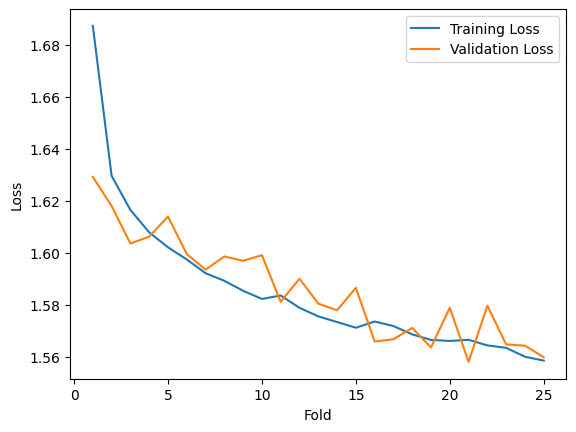

In [5]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

n = 5
kfold = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)

model = Classifier().to(device)
train_losses, val_losses = [], []

# 데이터셋을 교차 검증용으로 나누기
for fold, (train_idx, val_idx) in enumerate(kfold.split(training_data.data, training_data.targets)):
    print(f"Fold {fold + 1}")

    # dataloader 생성
    train_dataset = Subset(training_data, train_idx)
    val_dataset = Subset(training_data, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    train_loss, val_loss = CrossValidation(model, train_loader, val_loader, num_epochs=n)
    
    train_losses = train_losses + train_loss
    val_losses = val_losses + val_loss

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Dropout 적용

In [6]:
class ClassifierWithDropout(nn.Module):
    def __init__(self, dropout_prob = 0.3):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.linear2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.softmax(self.linear2(x), dim = 1)
        return x

Accuracy in epoch  1 : 35633/48000 (74.24%)
Accuracy in epoch  2 : 38008/48000 (79.18%)
Accuracy in epoch  3 : 38500/48000 (80.21%)
Accuracy in epoch  4 : 39174/48000 (81.61%)
Accuracy in epoch  5 : 40260/48000 (83.88%)
Accuracy in epoch  6 : 40694/48000 (84.78%)
Accuracy in epoch  7 : 40837/48000 (85.08%)
Accuracy in epoch  8 : 41143/48000 (85.71%)
Accuracy in epoch  9 : 41261/48000 (85.96%)
Accuracy in epoch 10 : 41387/48000 (86.22%)


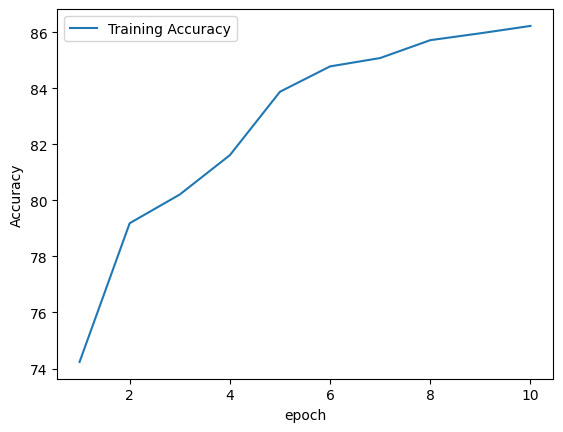

In [7]:
Acc_list = []

def train(epoch, model, dataloader):
    cnt = 0
    Accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.000523)
    
    for cnt in range(epoch):
        model.train()
        correct = 0
        
        for data, targets in dataloader:
            data = data.reshape(-1, 28*28).to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
        
        data_num = len(dataloader.dataset)
        cnt += 1
        accuracy = 100 * correct.to('cpu') / data_num # 뒤에 계산 때문에 cpu로 옮김.
        print("Accuracy in epoch {:2d} : {}/{} ({:.2f}%)".format(cnt, correct, data_num, accuracy))
        Accuracy.append(accuracy)
    
    return Accuracy

model = ClassifierWithDropout().to(device)

acc = train(10, model, train_loader)

plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
def eval(model, dataloader):
    model.eval()  # 모델을 평가 모드로 전환
    correct = 0

    with torch.no_grad():
        for data, targets in dataloader:
            data = data.reshape(-1, 28*28).to(device)
            targets = targets.to(device)

            outputs = model(data)
            predicted = torch.argmax(outputs, 1)
            correct += predicted.eq(targets.view_as(predicted)).sum()

    data_num = len(dataloader.dataset)
    accuracy = 100 * correct.to('cpu') / data_num
    print("Test Accuracy: {}/{} ({:.2f}%)".format(correct, data_num, accuracy))

    return accuracy

## Model Save & Load

In [9]:
# 모델과 옵티마이저 상태를 저장
model = ClassifierWithDropout().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epoch = 5
train(epoch, model, train_loader)
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_checkpoint.pth')
result = eval(model, test_loader)

Accuracy in epoch  1 : 35639/48000 (74.25%)
Accuracy in epoch  2 : 39100/48000 (81.46%)
Accuracy in epoch  3 : 39988/48000 (83.31%)
Accuracy in epoch  4 : 40330/48000 (84.02%)
Accuracy in epoch  5 : 40689/48000 (84.77%)
Test Accuracy: 8390/10000 (83.90%)


In [10]:
new_model = ClassifierWithDropout().to(device)
checkpoint = torch.load('model_checkpoint.pth')
new_model.load_state_dict(checkpoint['model_state_dict'])

result = eval(new_model, test_loader)

Test Accuracy: 8390/10000 (83.90%)


## Callback 함수
### Save-best-only
콜백은 훈련 중간에 작업을 수행하는 객체로 여기서는 점수가 가장 높을 때의 parammeter를 저장하는 용도로 사용해 보겠다.
keras에서는 callback 함수가 내장되어 있지만 pytorch에서는 내장되어 있지 않다; 그래서 직접 만들어 보는 걸로.

In [11]:
import math as m

def callback(model):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, 'best_model.pth')

def train_callback(epoch, model, dataloader):
    cnt = 0
    max = -m.inf
    Accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.000523)
    
    for cnt in range(epoch):
        model.train()
        correct = 0
        
        for data, targets in dataloader:
            data = data.reshape(-1, 28*28).to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
        
        data_num = len(dataloader.dataset)
        cnt += 1
        accuracy = 100 * correct.to('cpu') / data_num # 뒤에 계산 때문에 cpu로 옮김.
        print("Accuracy in epoch {:2d} : {}/{} ({:.2f}%)".format(cnt, correct, data_num, accuracy))
        Accuracy.append(accuracy)
        
        if accuracy > max:
            callback(model)
                
    return Accuracy

train_callback(5, model, train_loader)

best_model = ClassifierWithDropout().to(device)
checkpoint_best = torch.load('best_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

result = eval(best_model, test_loader)

Accuracy in epoch  1 : 40849/48000 (85.10%)
Accuracy in epoch  2 : 41061/48000 (85.54%)
Accuracy in epoch  3 : 41190/48000 (85.81%)
Accuracy in epoch  4 : 41373/48000 (86.19%)
Accuracy in epoch  5 : 41512/48000 (86.48%)
Test Accuracy: 8390/10000 (83.90%)


### Early-Stopping
다른 경우로는 모델의 정확도가 오차 범위 내에서 더 이상 오르지 않을 때 학습을 중지하는 early-stopping이 있다.

In [12]:
def train_earlystop(epoch, model, dataloader):
    cnt = 0
    esc = 0 # early-stop-count
    Accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.000523)
    
    for cnt in range(epoch):
        model.train()
        correct = 0
        
        for data, targets in dataloader:
            data = data.reshape(-1, 28*28).to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            predicted = torch.argmax(outputs.data, 1)
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
        
        data_num = len(dataloader.dataset)
        cnt += 1
        accuracy = 100 * correct.to('cpu') / data_num # 뒤에 계산 때문에 cpu로 옮김.
        print("Accuracy in epoch {:2d} : {}/{} ({:.2f}%)".format(cnt, correct, data_num, accuracy))
        
        # Early Stopping
        if len(Accuracy):
            flag = abs(Accuracy[-1] - accuracy)
            if flag < 0.5:
                esc += 1
            if esc == 5:
                print("early stopped!")
                break
        else : esc = 0
        
        Accuracy.append(accuracy)
                
    return Accuracy

new_model = ClassifierWithDropout().to(device)
result = train_earlystop(100, new_model, train_loader)

Accuracy in epoch  1 : 36474/48000 (75.99%)
Accuracy in epoch  2 : 39451/48000 (82.19%)
Accuracy in epoch  3 : 40010/48000 (83.35%)
Accuracy in epoch  4 : 40387/48000 (84.14%)
Accuracy in epoch  5 : 40745/48000 (84.89%)
Accuracy in epoch  6 : 40950/48000 (85.31%)
Accuracy in epoch  7 : 41073/48000 (85.57%)
Accuracy in epoch  8 : 41265/48000 (85.97%)
Accuracy in epoch  9 : 41401/48000 (86.25%)
Accuracy in epoch 10 : 41499/48000 (86.46%)
early stopped!
